<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/gradient-descent/grad_descent_dls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
import matplotlib.pyplot as plt


from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [2]:
%matplotlib inline

## Gradient descent naive representation

### Create a function

In [3]:
def f(x):
    """
    :param x: np.array(np.float) vector length 2
    :return: np.float
    """
    return np.sum(np.sin(x)**2)

### Analytical approach to calculate gradient

In [4]:
def grad_f(x):
    """
    gradinet of f func.
    :param x: np.array[2]: float vector length 2
    :return: np.array[2]: float vector length  2
    """
    grad_x = 2 * np.sin(x[0]) * np.cos(x[0])
    grad_y = 2 * np.sin(x[1]) * np.cos(x[1])
    return np.array([grad_x, grad_y])

#### Bathe in tests

In [5]:
assert np.allclose(grad_f(np.array([1, 2])),
                   np.array([0.90929743, -0.7568025])), "Something's wrong!"

### Implement gradient descent

In [6]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    grad descent for 2 variables
        :param f: scalar f for 2 vars
        :param grad_f: func returns grad of func f (only for grad_f impleimentation)
        :param lr: learning rate
        :param num_iter: number of alg iterations
        :return: np.array[num_iter, 2]  (x, f(x))
    """
    if x0 is None:
        x0 = np.random.random(2)

    # saving the learning history
    history = []

    # grad cycle
    curr_x = x0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_x, f(curr_x)))
        history.append(entry)

        curr_x -= grad_f(entry) * lr

    return np.vstack(history)

#### Visualize

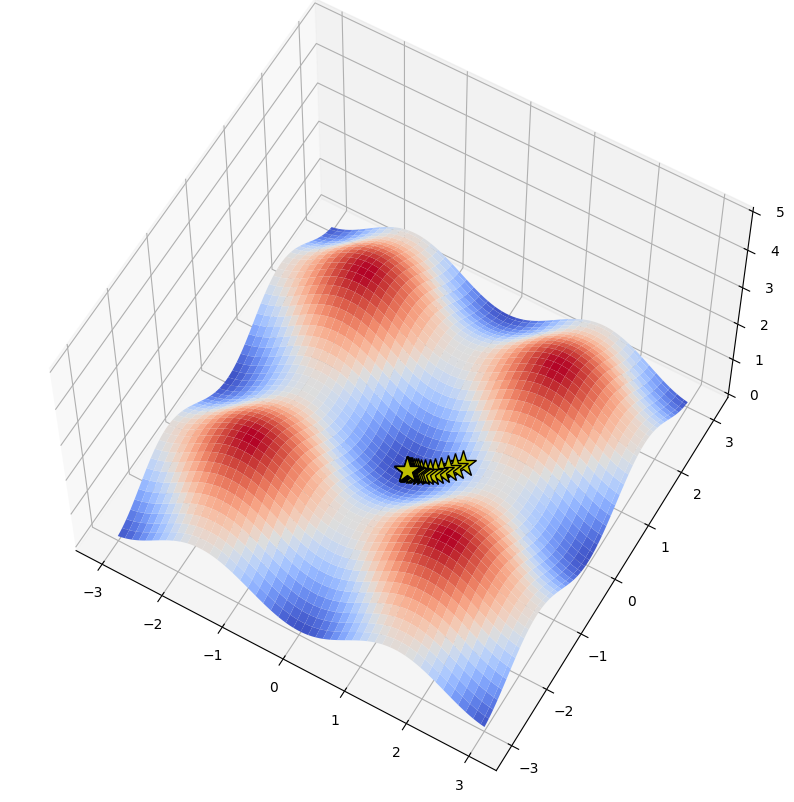

In [7]:
steps = grad_descent_2d(f, grad_f, lr=0.1, num_iter=20)
path = []
X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(projection='3d')

zs = np.array([f(np.array([x,y]))
              for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)


ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
        marker='*', markersize=20, zorder=3,
        markerfacecolor='y', lw=3, c='black')

ax.set_zlim(0, 5)
ax.view_init(elev=60)
plt.show()

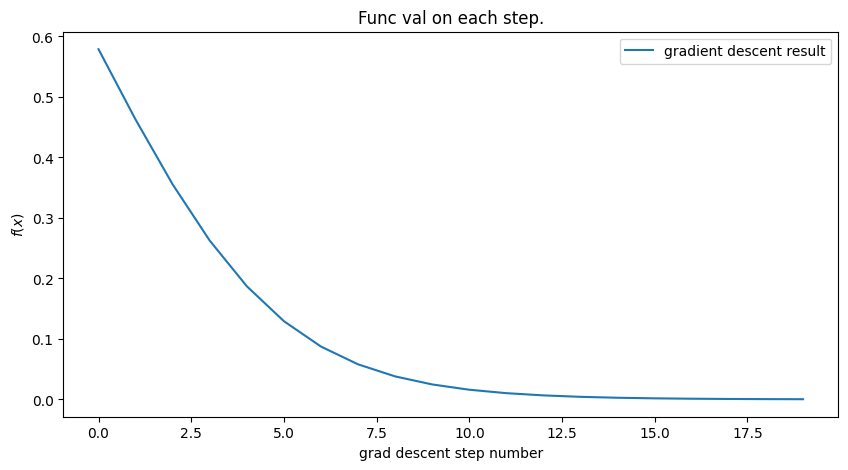

In [10]:
plt.figure(figsize=(10,5))
plt.xlabel('grad descent step number')
plt.ylabel('$f(x)$')
plt.title('Func val on each step.')

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label='gradient descent result')
plt.legend()

## Batch generator

In [35]:
def generate_batches(X, y, batch_size):
    """
    param X: np.array[n_objects, n_features] --- features matrix
    param y: np.array[n_objects] --- targer vals
    """
    assert len(X) == len(y)
    np.random.seed(42)
    X = np.array(X)
    y = np.array(y)
    perm = np.random.permutation(len(X))

    batches_num = len(X) // batch_size

    for batch_start in range(batches_num):
        bidx = perm[batch_start*batch_size : (batch_start+1)*batch_size]
        yield (X[bidx], y[bidx])




In [36]:
X_fake = X_fake = np.arange(100)
y_fake = np.arange(100) + 1000

X_reconstructed, y_reconstructed = [], []
for X_batch, y_batch in generate_batches(X_fake, y_fake, 10):
    X_reconstructed.append(X_batch)
    y_reconstructed.append(y_batch)

X_reconstructed = np.concatenate(X_reconstructed)
y_reconstructed = np.concatenate(y_reconstructed)

assert (X_fake != X_reconstructed).all(), "sumtinrong"
assert (y_fake != y_reconstructed).all(), "sumtinrong"

assert (np.sort(X_reconstructed, axis=0) == X_fake).all(), "sumtinrong"

X_fake = np.arange(100)
y_fake = np.arange(100) + 1000

num_batches = 0
for X_batch, y_batch in generate_batches(X_fake, y_fake, 7):
    num_batches += 1

assert num_batches == len(X_fake) // 7, "sumtinrong"

## LogReg

In [41]:
class MyLogisticRegression(object):
    def __init__(self):
        self.w = None


    @staticmethod
    def logit(x, w):
      return np.dot(x, w)


    @staticmethod
    def sigmoid(h):
      return 1. / (1 + np.exp(-h))


    @property
    def get_weights(self):
        return self.w.copy()


    def set_weights(self, w):
        self.w = w


    def sig(self, X):
      cur_logit = self.logit(X, self.get_weights)
      return self.sigmoid(cur_logit)


    def fit(self, X, y, epochs=10, lr=0.1, batch_size=100):
        n, k = X.shape
        if self.w is None:
            np.random.seed(42)
            self.w = np.random.randn(k + 1)

        X_train = np.concatenate((np.ones((n, 1)), X), axis=1)
        losses = []
        for i in range(epochs):
            for X_batch, y_batch in generate_batches(X_train, y, batch_size):

                grad = self.get_grad(X_batch, y_batch, self.sig(X_batch))
                new_w = self.w - lr * grad
                self.set_weights(new_w)
                loss = self.__loss(y_batch, self.sig(X_batch))
                assert (np.array(loss).shape == tuple()), "Loss should be scalar!"
                losses.append(loss)
        return losses


    def get_grad(self, X_batch, y_batch, predictions):
        """
        param X_batch: np.array[batch_size, n_features + 1] --- feature matrix
        param y_batch: np.array[batch_size] --- target batch
        param predictions: np.array[batch_size] --- proba class batch

        return (np.array[n_features + 1])
        """
        grad_basic = X_batch.T @ (predictions - y_batch)
        assert grad_basic.shape == (X_batch.shape[1],) , "grads should k_features + 1 columns"
        return grad_basic


    def predict_proba(self, X):
        n, k = X.shape
        X_ = np.concatenate((np.ones((n, 1)), X), axis=1)
        return self.sig(X_)


    def _predict_proba_internal(self, X):
        return self.sig(X)


    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold


    def __loss(self, y, p):
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))

### Bathe in tests

In [42]:
m = MyLogisticRegression()
X = np.array([[1, 3, 4], [1, -5, 6], [-3, 5, 3]])
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
y = np.array([1, 0, 1])
preds = np.array([.55, .22, .85])
grads = m.get_grad(X, y, preds)
assert np.allclose(grads, np.array([-0.38,  0.22, -3.2 , -0.93])), "sumtinrong!"
np.random.seed(42)
m = MyLogisticRegression()
X = np.random.rand(100,3)
y = np.random.randint(0, 1, size=(100,))
preds = np.random.rand(100)
grads = m.get_grad(X, y, preds)
assert np.allclose(grads, np.array([23.8698149, 25.27049356, 24.4139452])), "sumtinrong!"